In [24]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
%load_ext autoreload
%autoreload 2

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import sys
sys.path.append('../../')
from VisUtils import *
from split_data import *
from GPUtils import * 
# from GPUtils import DirichletGPModel
from sklearn.metrics import confusion_matrix
import itertools

from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, PrecisionRecallDisplay

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
split_path = '../../../../../data/NEK_data_4Berkeley/NEK2/bind/'

train_x_df_temp = pd.read_csv(split_path+"bind_train_x_UNDER.csv",header=None)
train_y_df_temp = pd.read_csv(split_path+"bind_train_y_UNDER.csv",header=None)
test_x_df = pd.read_csv(split_path+"bind_test_x_UNDER.csv",header=None)
test_y_df = pd.read_csv(split_path+"bind_test_y_UNDER.csv",header=None)

train_x_temp = train_x_df_temp.to_numpy().astype("long")
test_x_temp = test_x_df.to_numpy().astype("long")

train_y_temp = train_y_df_temp.to_numpy().flatten().astype("long")
test_y_temp = test_y_df.to_numpy().flatten().astype("long")

train_x = torch.from_numpy(train_x_temp)
train_y = torch.from_numpy(train_y_temp)
test_x = torch.from_numpy(test_x_temp)
test_y = torch.from_numpy(test_y_temp)


print(train_x.shape) 
print(train_y.shape) 

torch.Size([90, 306])
torch.Size([90])


In [26]:
class Trainer: 
    def __init__(self,model, likelihood, iterations): 
        self.model = model
        self.likelihood = likelihood 

        smoke_test = ('CI' in os.environ)
        self.n_iterations = 2 if smoke_test else iterations
        # self.n_iterations = n_iterations 
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        # loss function 
        self.loss_fn = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.model)
    def train(self, train_x, train_y): 
        self.model.train()
        self.likelihood.train()
        predictions = [] 
        for i in range(self.n_iterations): 
            self.optimizer.zero_grad()
            output = self.model(train_x)
            loss = -self.loss_fn(output, self.likelihood.transformed_targets).sum()
            loss.backward()
            if (i%10==0): 
                print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                    i + 1, self.n_iterations, loss.item(),
                    self.model.covar_module.base_kernel.lengthscale.mean().item(),
                    self.model.likelihood.second_noise_covar.noise.mean().item()
                ))
             
          
            self.optimizer.step() 


    def predict(self, input): 
        # predict on validation set? 
        self.model.eval()
        self.likelihood.eval()

        with gpytorch.settings.fast_pred_var(), torch.no_grad():
            dist = self.model(input)     # output distribution
            pred_means = dist.loc          # means of distributino 
            # f_samples = dist.sample(sample_shape=torch.Size(1000))    
            observed_pred = self.likelihood(self.model(input))    # likelihood predictions mean and var  
            # class_pred = self.model(input).loc.max(0)[1].numpy()  # predictions (0 or 1) 
            class_pred = self.model(input).loc.max(0)[1]
            
        return dist, observed_pred, pred_means,class_pred
    

    def evaluate(self, x_input, y_true): 
        y_pred = self.model(x_input).loc.max(0)[1].numpy()
        
        return y_pred

    def gp_results(self, x_input, y_true, plot_title): 
        y_pred = self.evaluate(x_input, y_true) 
        if isinstance(y_true, torch.Tensor):
            y_true = y_true.numpy().reshape(-1)
        # cm = confusion_matrix(y_true, y_pred)
        plot_confusion_matrix(y_true, y_pred, ['0','1'], title=plot_title)
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        dist = self.model(x_input)     # get predicted distributions 
        pred_means = dist.loc          # means for predicted dist  

        recall = recall_score(y_true, y_pred)
        tp, tn, fp, fn = calculate_metrics(y_true, y_pred) 
        sensitivity = tp / (tp + fn) 
        specificity = tn / (tn + fp) 
        print(f'accuracy: {accuracy:.3f}, precision: {precision:.3f}, recall: {recall:.3f}, specificity: {specificity:.3f}')
        return {'accuracy': accuracy, 'precision': precision,  'recall':recall, 'specificity':specificity}

       

In [27]:
likelihood1 = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model1 = DirichletGPModel(train_x, likelihood1.transformed_targets, likelihood1, num_classes=likelihood1.num_classes)
n_iterations = 300
trainer1 = Trainer(model1, likelihood1, n_iterations)
trainer1.train(train_x, train_y) 

Iter 1/300 - Loss: 7.107   lengthscale: 0.693   noise: 0.693
Iter 11/300 - Loss: 5.931   lengthscale: 0.887   noise: 1.297
Iter 21/300 - Loss: 5.439   lengthscale: 1.232   noise: 1.982
Iter 31/300 - Loss: 5.262   lengthscale: 1.919   noise: 2.574
Iter 41/300 - Loss: 5.193   lengthscale: 2.970   noise: 3.007
Iter 51/300 - Loss: 5.166   lengthscale: 4.199   noise: 3.295
Iter 61/300 - Loss: 5.144   lengthscale: 5.251   noise: 3.461
Iter 71/300 - Loss: 5.134   lengthscale: 5.884   noise: 3.519
Iter 81/300 - Loss: 5.128   lengthscale: 6.062   noise: 3.503
Iter 91/300 - Loss: 5.123   lengthscale: 6.026   noise: 3.439
Iter 101/300 - Loss: 5.120   lengthscale: 6.000   noise: 3.347
Iter 111/300 - Loss: 5.118   lengthscale: 6.070   noise: 3.238
Iter 121/300 - Loss: 5.115   lengthscale: 6.177   noise: 3.125
Iter 131/300 - Loss: 5.114   lengthscale: 6.241   noise: 3.012
Iter 141/300 - Loss: 5.112   lengthscale: 6.257   noise: 2.900
Iter 151/300 - Loss: 5.110   lengthscale: 6.267   noise: 2.786
Ite

accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
accuracy: 0.689, precision: 0.087, recall: 0.667, specificity: 0.690


/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


<Figure size 600x400 with 0 Axes>

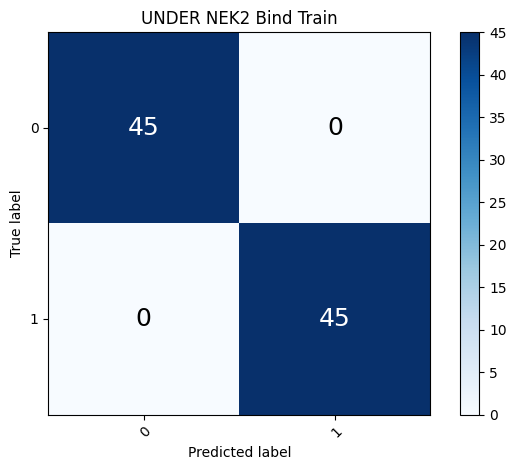

<Figure size 600x400 with 0 Axes>

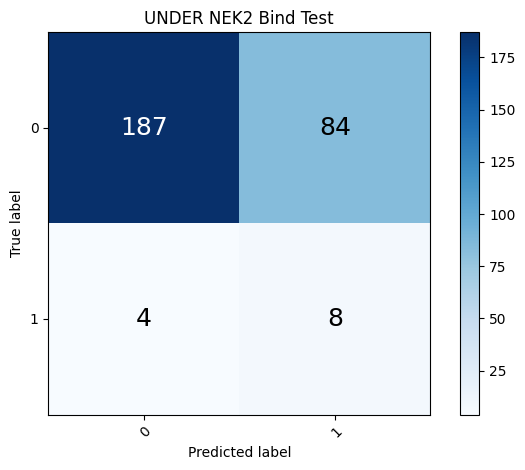

In [28]:
# get predictions of train x input
train_dist, train_observed_pred, train_pred_means, train_pred  = trainer1.predict(train_x)
train_results1 = trainer1.gp_results(train_x, train_y, 'UNDER NEK2 Bind Train')

test_dist, test_observed_pred, test_pred_means, test_pred  = trainer1.predict(test_x)
test_results1 = trainer1.gp_results(test_x, test_y, 'UNDER NEK2 Bind Test')


In [29]:
gp_metrics = [train_results1, test_results1]
with open('bind_gp_metrics_UNDER.pkl', 'wb') as file: 
    pickle.dump(gp_metrics, file) 

In [30]:
# train_pred = train_observed_pred
train_observed_pred.mean.numpy()
train_pred_variance2D = train_observed_pred.variance.numpy()
# test_pred = test_observed_pred
test_observed_pred.mean.numpy()
test_pred_variance2D=test_observed_pred.variance.numpy()
var_min = test_pred_variance2D.min(axis=0).min()
var_max = test_pred_variance2D.max(axis=0).max()
var_min, var_max
# train_observed_pred.variance.numpy()
# test_observed_pred.variance.numpy()

(3.515955, 7.5603967)

In [31]:

train_pred_samples = train_dist.sample(torch.Size((256,))).exp()
train_probabilities = (train_pred_samples / train_pred_samples.sum(-2, keepdim=True)).mean(0)
train_probabilities.shape 
train_prob_stds = (train_pred_samples / train_pred_samples.sum(-2, keepdim=True)).std(0)
train_prob_stds.shape

lower, upper = test_observed_pred.confidence_region()

# # Generate samples to get probabilities
pred_samples = test_dist.sample(torch.Size((100,))).exp()
pred_samples.shape
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
prob_stds = (pred_samples / pred_samples.sum(-2, keepdim=True)).std(0)


In [32]:
train_perf_df = pd.DataFrame()
test_perf_df = pd.DataFrame()
train_perf_df['mean_pred_class0'] = train_observed_pred.mean.numpy()[0,]
train_perf_df['mean_pred_class1'] = train_observed_pred.mean.numpy()[1,]
train_perf_df['y'] = train_y
train_perf_df['y_pred'] = train_pred_means.max(0)[1]
train_perf_df['var_pred_class0']=train_observed_pred.variance.numpy()[0,]
train_perf_df['var_pred_class1']=train_observed_pred.variance.numpy()[1,]
train_perf_df['pred_prob_class0'] = train_probabilities.numpy()[0,]
train_perf_df['pred_prob_class1'] = train_probabilities.numpy()[1,]
train_perf_df['pred_prob_std_class0'] = train_prob_stds.numpy()[0,]
train_perf_df['pred_prob_std_class1'] = train_prob_stds.numpy()[1,]

test_perf_df['mean_pred_class0'] = test_observed_pred.mean.numpy()[0,]
test_perf_df['mean_pred_class1'] = test_observed_pred.mean.numpy()[1,]
test_perf_df['y'] = test_y
test_perf_df['y_pred'] = test_pred_means.max(0)[1]
test_perf_df['var_pred_class0']=test_observed_pred.variance.numpy()[0,]
test_perf_df['var_pred_class1']=test_observed_pred.variance.numpy()[1,]
test_perf_df['pred_prob_class0'] = probabilities.numpy()[0,]
test_perf_df['pred_prob_class1'] = probabilities.numpy()[1,]
test_perf_df['pred_prob_std_class0'] = prob_stds.numpy()[0,]
test_perf_df['pred_prob_std_class1'] = prob_stds.numpy()[1,]

train_perf_df.to_csv("NEK2_bind_UNDER_train_perf.csv", index=False)
test_perf_df.to_csv("NEK2_bind_UNDER_test_perf.csv", index=False)

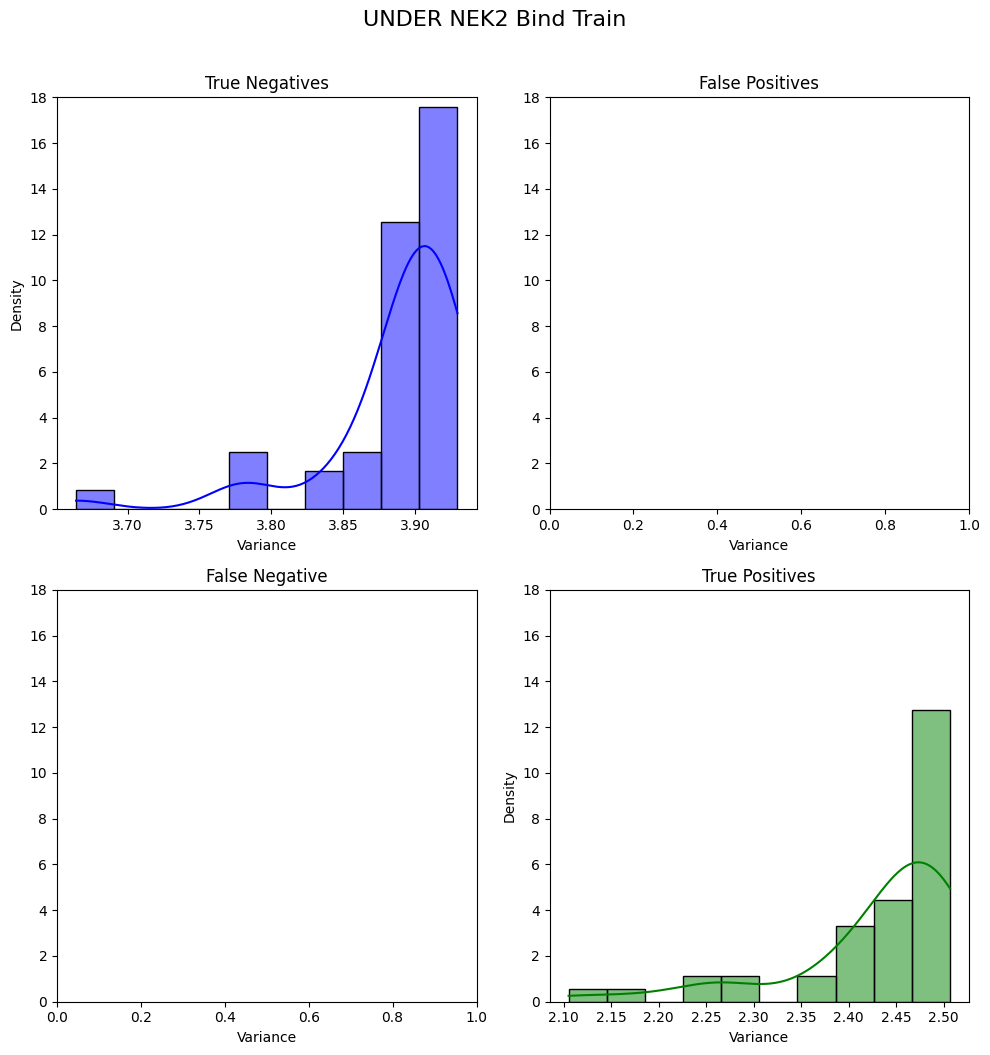

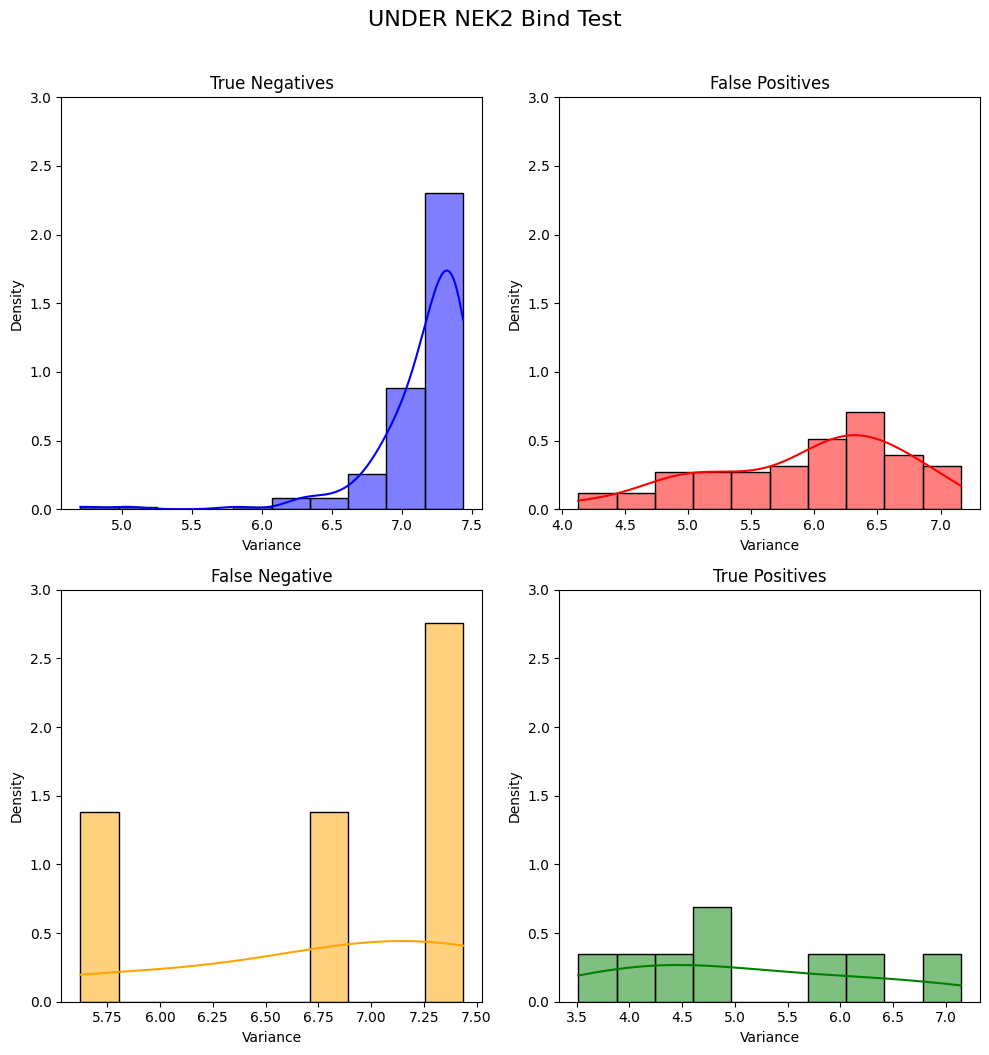

In [36]:
plot_cm_dist_kdedensity(train_observed_pred, train_pred, train_y, 'UNDER NEK2 Bind Train',18)
plot_cm_dist_kdedensity(test_observed_pred, test_pred, test_y, 'UNDER NEK2 Bind Test',3)

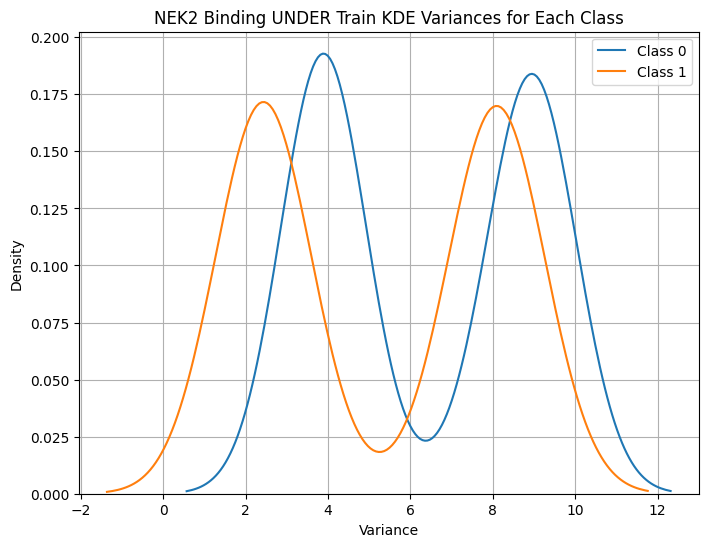

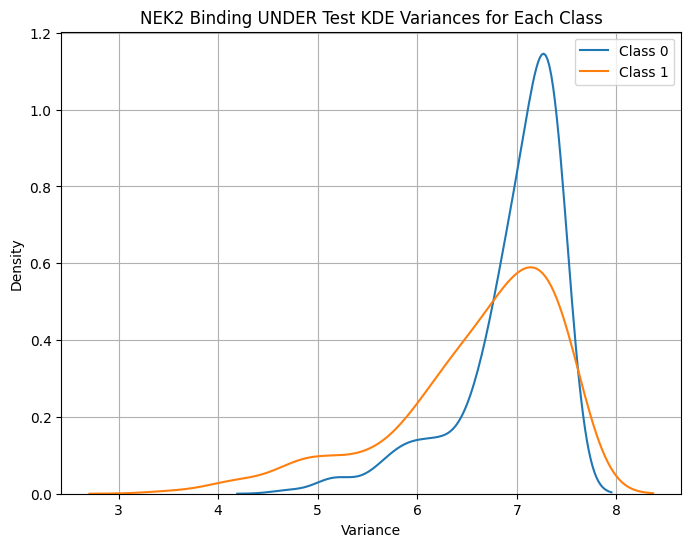

In [37]:
plot_kde(train_observed_pred, 'NEK2 Binding UNDER Train')
plot_kde(test_observed_pred, 'NEK2 Binding UNDER Test')

In [38]:
test_observed_pred.mean.numpy() # test_pred.mean.numpy()  observed_pred = self.likelihood(self.model(input)) 
test_pred_variance2D = test_observed_pred.variance.numpy()
print(test_observed_pred.variance.numpy().shape)
test_pred_variance2D
test_pred_variance = [test_pred_variance2D[value][idx] for idx,value in enumerate(test_pred)]

(2, 283)


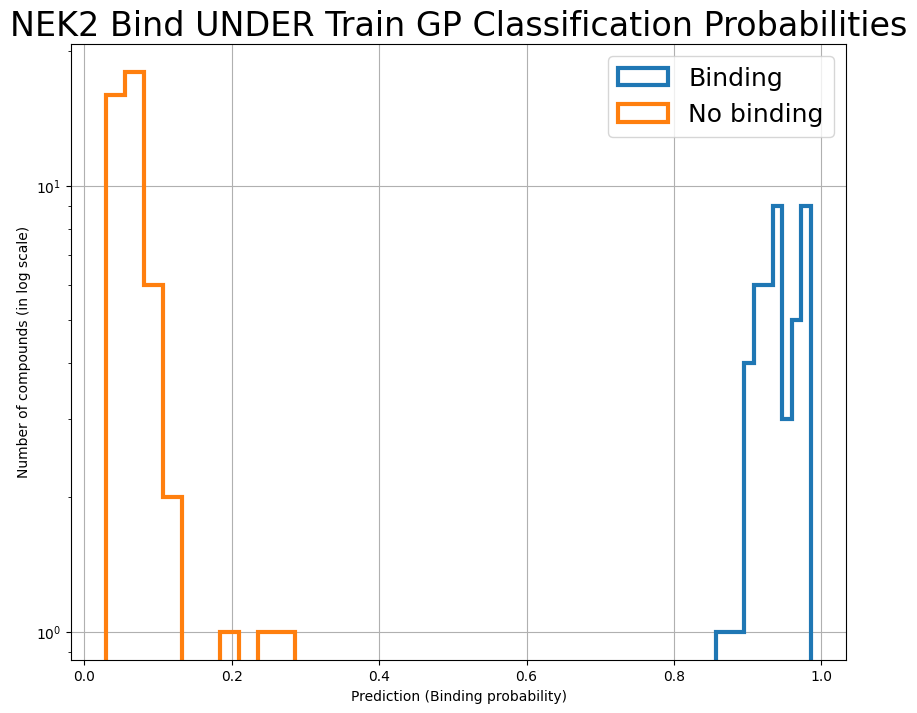

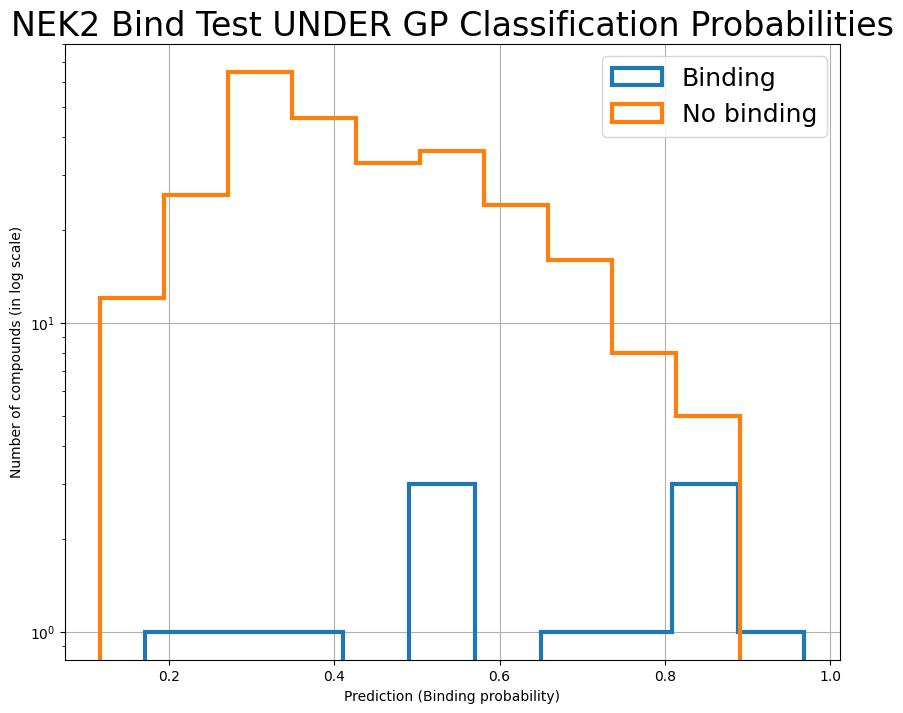

In [39]:

plot_prob_hist(train_probabilities, train_y, 'NEK2 Bind UNDER Train GP Classification Probabilities', 'Binding')
plot_prob_hist(probabilities, test_y, 'NEK2 Bind Test UNDER GP Classification Probabilities', 'Binding')

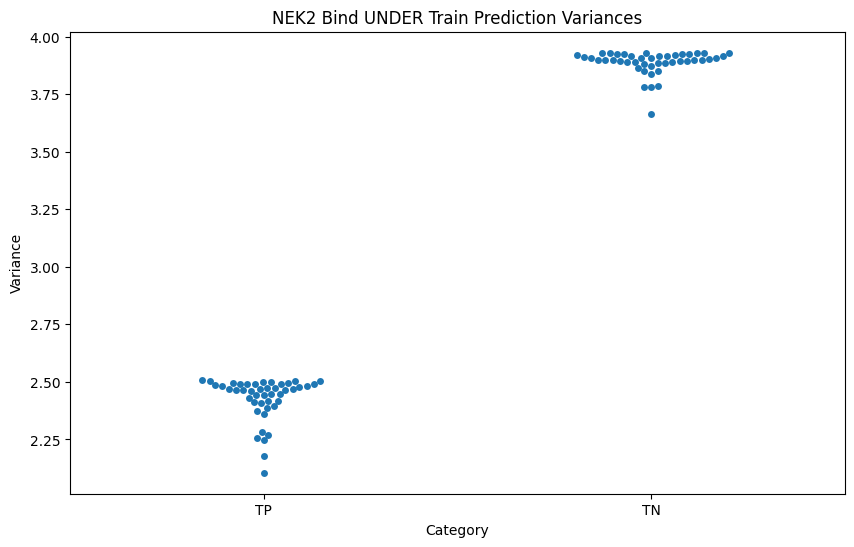

/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 11.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 18.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


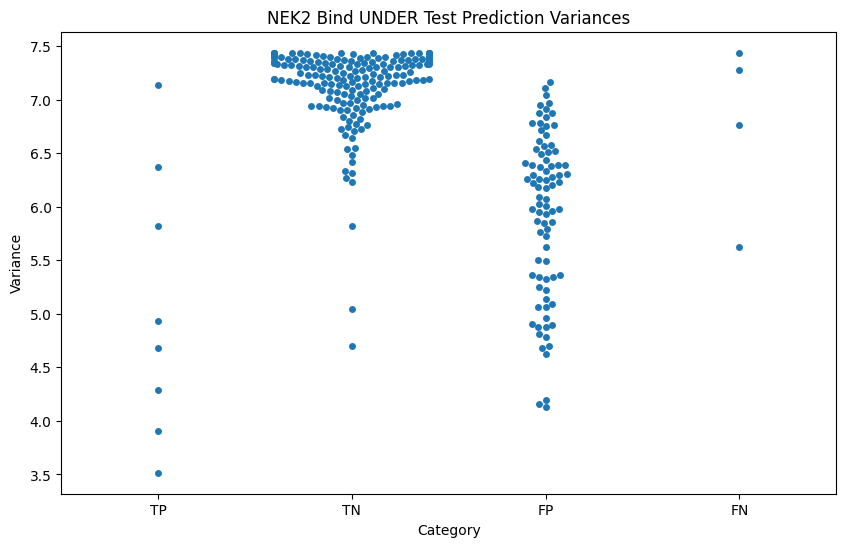

In [40]:
plot_swarmplot(train_pred, train_y, train_observed_pred,'NEK2 Bind UNDER Train Prediction Variances')
plot_swarmplot(test_pred, test_y, test_observed_pred,'NEK2 Bind UNDER Test Prediction Variances')

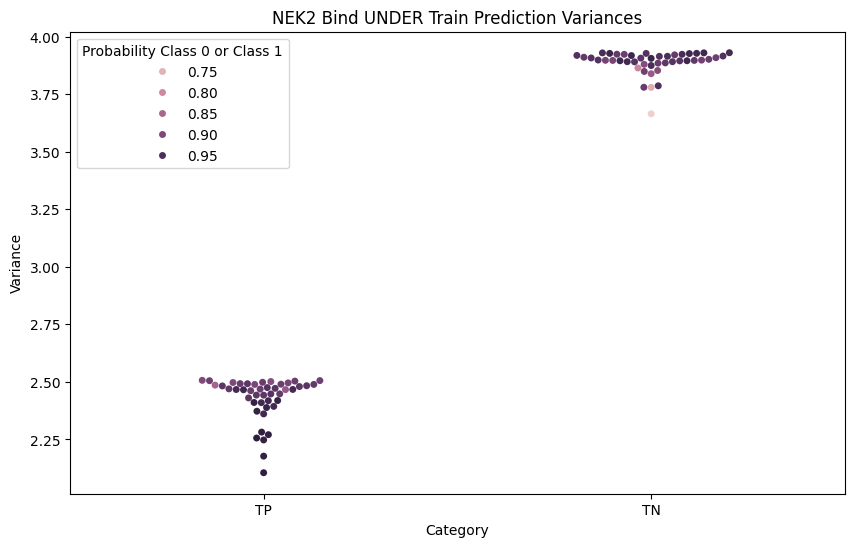

/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 11.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 18.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


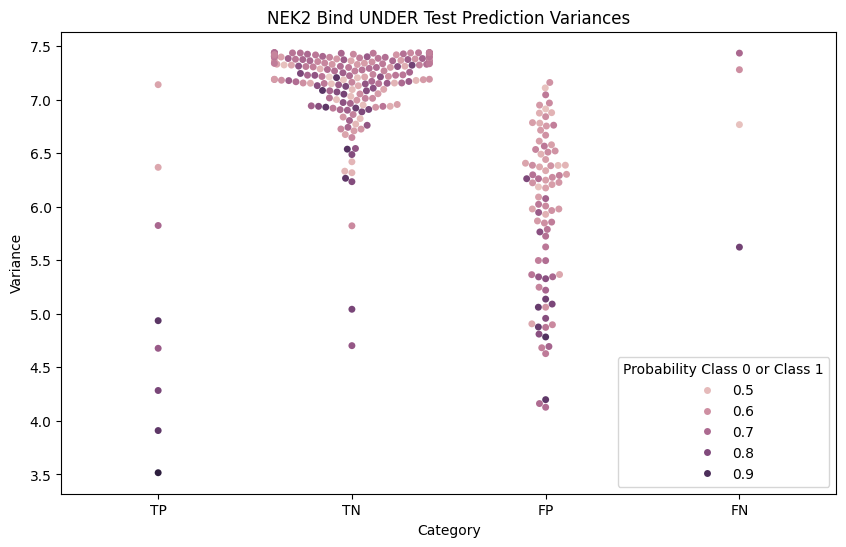

In [43]:
swarm_by_var_and_prob(train_pred, train_y, train_observed_pred,train_probabilities,'NEK2 Bind UNDER Train Prediction Variances')
swarm_by_var_and_prob(test_pred, test_y, test_observed_pred,probabilities,'NEK2 Bind UNDER Test Prediction Variances')

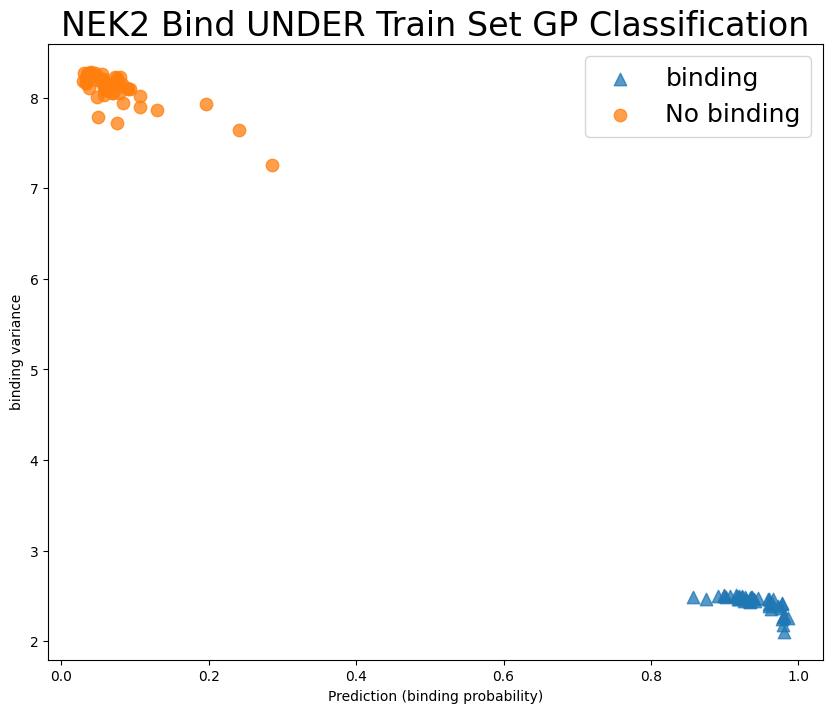

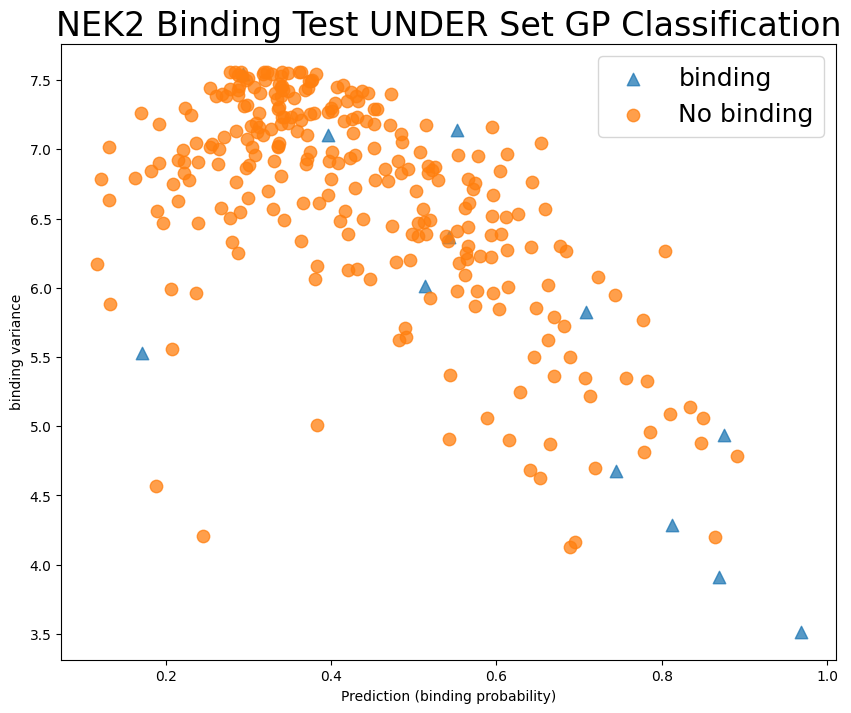

In [41]:
probabilities_vs_var(train_y, train_probabilities, train_observed_pred,'NEK2 Bind UNDER Train Set GP Classification', 'binding')
probabilities_vs_var(test_y, probabilities, test_observed_pred,'NEK2 Binding Test UNDER Set GP Classification', 'binding')